In [4]:
# rmt_analysis_from_close_matrix.py
# 适配你的 extract_close_matrix_real_trading_days 输出（P, codes, dates）
# 运行前确保：
#   tushare_pro_data/close_matrix.npy 存在（或修改 CLOSE_PATH）
#   如有 codes.npy 和 dates.npy 也可放在同一目录以便展示代码/日期

import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import akshare as ak

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def safe_get_name_and_industry(code):
    """
    输入：清洗后的股票代码（如 '600519', '000858'）
    输出：pd.Series({'stock_name': ..., 'industry': ...})
    """
    try:
        # 调用 akshare 获取个股信息
        df_info = ak.stock_individual_info_em(symbol=code)
        
        # 提取“股票简称”和“所属行业”
        name_row = df_info[df_info['item'] == '股票简称']
        industry_row = df_info[df_info['item'] == '行业']

        stock_name = name_row['value'].values[0] if not name_row.empty else 'Unknown'
        industry = industry_row['value'].values[0] if not industry_row.empty else 'Unknown'

        return pd.Series({'stock_name': stock_name, 'industry': industry})

    except Exception as e:
        # 捕获所有异常（网络、解析、代码无效等）
        print(f"⚠️ 获取 {code} 信息失败: {e}")
        return pd.Series({'stock_name': 'Error', 'industry': 'Error'})
    
    finally:
        time.sleep(0.5)  # 防止请求过快被封

def load_close_matrix(path, codes_path=None, dates_path=None, recent_days=None):
    """
    加载收盘价矩阵，并可选择只返回最近 N 个交易日

    Args:
        path: str, close matrix npy 文件路径
        codes_path: str or None, 股票代码 npy 文件路径
        dates_path: str or None, 日期 npy 文件路径
        recent_days: int or None, 只保留最近多少个交易日（从右往左）

    Returns:
        P: np.ndarray, shape (N, T')，最近 recent_days 个交易日的矩阵
        codes: list of str, 股票代码
        dates: list of pd.Timestamp, 对应交易日期
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"找不到 close matrix: {path}")
    
    P = np.load(path)  # expected shape (N, T)
    N, T = P.shape
    codes = None
    dates = None

    if codes_path and os.path.exists(codes_path):
        codes = np.load(codes_path, allow_pickle=True).tolist()
    if dates_path and os.path.exists(dates_path):
        dates = np.load(dates_path, allow_pickle=True).tolist()
        try:
            dates = pd.to_datetime(dates)
        except Exception:
            pass

    if codes is None:
        codes = [f"stock_{i}" for i in range(N)]
        print("⚠️ 未找到 codes.npy，使用默认代码名")
    if dates is None:
        dates = pd.bdate_range(end=pd.Timestamp.today(), periods=T).tolist()
        print("⚠️ 未找到 dates.npy，使用默认日期")

    # ---------------- 选择最近交易日 ----------------
    if recent_days is not None and recent_days < T:
        P = P[:, -recent_days:]         # 取最后 recent_days 列
        dates = dates[-recent_days:]    # 对应日期

    return P, codes, dates

def compute_all_return_df(P, codes, dates):
    """
    Compute standardized log returns as in your snippet:
    for each code: log(close / close.shift(1)), then z-score per stock.
    Return a pandas DataFrame all_return with columns = codes, index = trade dates (T-1).
    """
    N, T = P.shape
    # Build DataFrame with columns = codes, rows indexed by dates
    # Note: P rows = stocks, cols = dates -> transpose to DataFrame with index=dates
    close_df = pd.DataFrame(P.T, index=dates, columns=codes)  # shape (T, N)
    # compute log returns per column (stock)
    logret = np.log(close_df / close_df.shift(1))
    # drop first row (NaN) as in your snippet
    logret = logret.iloc[1:, :]
    # standardize per stock (z-score)
    all_return = (logret - logret.mean()) / logret.std(ddof=1)
    # replace infinite/nan with 0 (if any stock had zero std or all NaN)
    all_return = all_return.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return all_return

def marchenko_pastur(Q):
    """
    Returns lambda_minus, lambda_plus for MP law when variance=1:
    lam_pm = (1 +/- 1/sqrt(Q))^2
    """
    lam_plus = (1 + 1.0/math.sqrt(Q))**2
    lam_minus = (1 - 1.0/math.sqrt(Q))**2
    return lam_minus, lam_plus

def mp_density(x, Q):
    """
    Compute MP density for array x given Q = T/N
    density = (Q / (2*pi*lambda)) * sqrt((lambda_plus - lambda)*(lambda - lambda_minus))
    valid for lambda in (lambda_minus, lambda_plus)
    """
    lam_minus, lam_plus = marchenko_pastur(Q)
    x = np.array(x)
    density = np.zeros_like(x, dtype=float)
    mask = (x > lam_minus) & (x < lam_plus)
    density[mask] = (Q / (2.0 * np.pi * x[mask])) * np.sqrt((lam_plus - x[mask])*(x[mask] - lam_minus))
    return density

def participation_ratio(eigvecs):
    """
    eigvecs: matrix shape (N, N) columns are eigenvectors
    PR_k = 1 / sum_i u_i^4
    Returns PR array length N (order corresponds to eigvecs columns)
    """
    # ensure float computation
    ev = np.array(eigvecs, dtype=float)
    pr = np.array([1.0 / np.sum(ev[:, k]**4) for k in range(ev.shape[1])])
    return pr #小 PR → 可能代表行业或特定股票主导的信号；大 PR → 属于随机噪声成分


def denoise_by_three_regions(vals, vecs, T, N):
    """
    Split eigenvalues into three regions by MP bounds:
        1) vals < lam_minus
        2) lam_minus <= vals <= lam_plus
        3) vals > lam_plus
    For each region, reconstruct a covariance matrix using only eigenvalues in that region.
    """
    lam_minus, lam_plus = marchenko_pastur(T / N)
    vals = np.array(vals)
    vecs = np.array(vecs, dtype=float)
    
    # masks
    mask_low = vals < lam_minus
    mask_bulk = (vals >= lam_minus) & (vals <= lam_plus)
    mask_high = vals > lam_plus
    
    lam_low = np.zeros_like(vals)
    lam_bulk = np.zeros_like(vals)
    lam_high = np.zeros_like(vals)
    
    # 区域赋值
    lam_low[mask_low] = vals[mask_low]
    lam_bulk[mask_bulk] = np.mean(vals[mask_bulk]) if np.any(mask_bulk) else 0.0
    lam_high[mask_high] = vals[mask_high]
    
    # 重构协方差矩阵
    cov_low = vecs @ np.diag(lam_low) @ vecs.T
    cov_bulk = vecs @ np.diag(lam_bulk) @ vecs.T
    cov_high = vecs @ np.diag(lam_high) @ vecs.T
    
    # 对称化
    cov_low = (cov_low + cov_low.T) / 2.0
    cov_bulk = (cov_bulk + cov_bulk.T) / 2.0
    cov_high = (cov_high + cov_high.T) / 2.0
    
    return cov_low, cov_bulk, cov_high, lam_minus, lam_plus

def min_variance_weights_from_cov(cov):
    """
    Unconstrained min variance: w ∝ Σ^{-1} 1, normalized to sum=1
    """
    N = cov.shape[0]
    eps = 1e-8
    cov_reg = cov + np.eye(N)*eps
    inv = np.linalg.inv(cov_reg)
    ones = np.ones(N)
    w = inv @ ones
    w = w / np.sum(w)
    return w

def long_only_from_weights(w):
    """Clip negatives and renormalize (simple heuristic)"""
    w_pos = np.clip(w, 0, None)
    s = w_pos.sum()
    if s <= 0:
        return np.ones_like(w) / len(w)
    return w_pos / s



Loaded close matrix: (532, 2138)
532 stocks
2138 trading days
Example codes: ['600000.SH', '600004.SH', '600007.SH', '600011.SH', '600015.SH']
Example dates: DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09'],
              dtype='datetime64[ns]', freq=None)
all_return shape: (2137, 532)  (rows = trade dates, cols = stocks)
Q = 4.016917, MP lam_minus = 0.251055, lam_plus = 2.246839


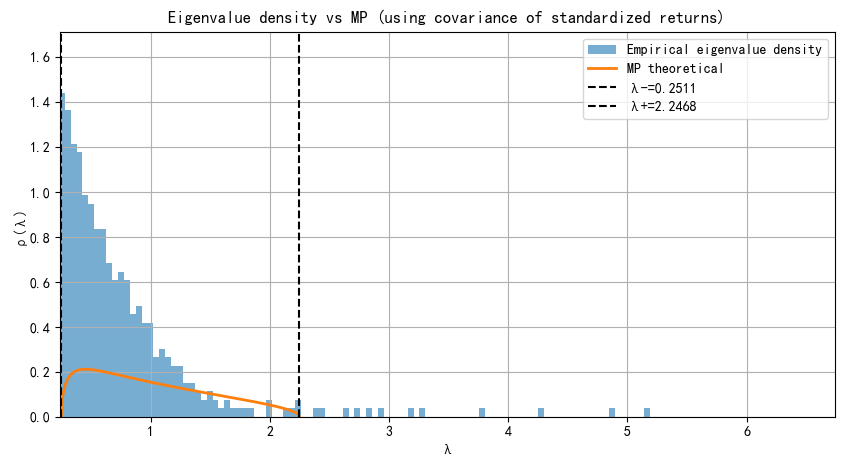

Found 139 eigenvalues outside MP bounds (out of 532)
Top 10 eigenvalues (desc): [140.239473  19.922705  13.566657  11.700355   7.721252   6.90395
   5.153298   4.878001   4.278313   3.772036]


In [5]:
   
# ---------------- 主程序 ----------------
# ---------------- Tushare 初始化 ----------------
import tushare as ts
import akshare as ak
ts.set_token('65209d394f51051f94f8a9eeeb3396048121ecf94080eda0e33d06e5')
pro = ts.pro_api()

# ---------------- config ----------------
CLOSE_PATH = "tushare_pro_data/close_matrix_sh.npy"   # 改为你的路径
CODES_PATH = "tushare_pro_data/codes_sh.npy"          # 可选
DATES_PATH = "tushare_pro_data/dates_sh.npy"          # 可选
SAVE_RESULTS = "tushare_pro_data/rmt_results.npz"
PLOT_BINS = 400
TOP_K = 9  # 展示前 K 个特征向量的贡献者
TOP_N_COMPONENTS = -1  # 每个特征向量展示前多少只股票
# ----------------------------------------

# 1) load_close_matrix 
P, codes, dates = load_close_matrix(CLOSE_PATH, CODES_PATH if os.path.exists(CODES_PATH) else None,
                                    DATES_PATH if os.path.exists(DATES_PATH) else None)
N, T = P.shape
print(f"Loaded close matrix: {P.shape}")
print(f"{N} stocks")
print(f"{T} trading days")
print("Example codes:", codes[:5])
print("Example dates:", dates[:5])

# 2) compute all_return (standardized log returns) -- DataFrame indexed by trade dates (T-1 rows)
all_return = compute_all_return_df(P, codes, dates)   # shape (T-1) x N
# Transpose concept: your original snippet built all_return with columns=stocks; keep that
# In our DF, index = dates[1:], columns = codes
trade_date_list = all_return.index.tolist()
stock_list = all_return.columns.tolist()
print(f"all_return shape: {all_return.shape}  (rows = trade dates, cols = stocks)")

# 3) covariance of returns (this matches your snippet: e, h = np.linalg.eigh(all_return.cov()))
cov_mat = all_return.cov()   # pandas DataFrame (N x N) with index/cols = stocks
# For numeric operations convert to numpy
cov_np = cov_mat.values
# eigen-decomposition (symmetric)
e_vals, h_vecs = np.linalg.eigh(cov_np)   # e_vals ascending, h_vecs columns are eigenvectors
# Keep variables names like your snippet
e = e_vals
h = h_vecs

# 4) MP theoretical bounds -- your formula uses Q = len(trade_date_list) / len(stock_list)
Q = len(trade_date_list) / len(stock_list)   # T / N (note trade_date_list length = T-1)
lam_plus = 1 + 1.0/Q + 2.0 * (1.0 / math.sqrt(Q))
lam_minus = 1 + 1.0/Q - 2.0 * (1.0 / math.sqrt(Q))
# equivalently lam_plus = (1 + 1/sqrt(Q))**2 etc.

print(f"Q = {Q:.6f}, MP lam_minus = {lam_minus:.6f}, lam_plus = {lam_plus:.6f}")

# 5) plot eigenvalue histogram and MP density
# e is ascending; convert to numpy array
e_np = np.array(e)
plt.figure(figsize=(10,5))
plt.hist(e_np[:-1], bins=PLOT_BINS, density=True, alpha=0.6, label="Empirical eigenvalue density")
x = np.linspace(max(0, lam_minus*0.9999), lam_plus*1.0001, 400)
y = []
for xi in x:
    # match your original discrete formula (pho)
    pho = math.sqrt((lam_plus - xi) * (xi - lam_minus)) / (2 * xi * math.pi) if (xi > lam_minus and xi < lam_plus) else 0.0
    y.append(pho)
plt.plot(x, y, linewidth=2, label="MP theoretical")
plt.axvline(lam_minus, linestyle='--', color='k', label=f"λ-={lam_minus:.4f}")
plt.axvline(lam_plus, linestyle='--', color='k', label=f"λ+={lam_plus:.4f}")
plt.xlim(lam_minus * 0.95,lam_plus*3)
#plt.ylim(0, 1)
plt.xlabel('λ')
plt.ylabel('ρ(λ)')
plt.title('Eigenvalue density vs MP (using covariance of standardized returns)')
plt.legend()
plt.grid(True)
plt.show()

# 6) find eigenvalues outside MP bounds
outlier_mask = (e_np < lam_minus) | (e_np > lam_plus)
outlier_indices = np.where(outlier_mask)[0]   # indices in ascending-sorted e
outlier_vals = e_np[outlier_indices]
print(f"Found {len(outlier_vals)} eigenvalues outside MP bounds (out of {len(e_np)})")

# show top few large eigenvalues (descending)
e_desc = e_np[::-1]
print("Top 10 eigenvalues (desc):", np.round(e_desc[:10], 6))

# 7) analyze one eigenvector (example: the 2nd largest in your earlier snippet used h[:, -2])
# In our h (columns are eigenvectors aligned with e ascending), so largest eigenvector is h[:, -1]
# We will analyze multiple outsides: for each outlier eigenvalue index show top components
eigen_info = []
# produce descending-sorted eigenvectors/values for convenience
idx_desc = np.argsort(e_np)[::-1]
e_desc = e_np[idx_desc]
h_desc = h[:, idx_desc]  # columns aligned to descending eigenvalues

# Participation ratio (for descending order)
PR = participation_ratio(h_desc)   # PR[k] corresponds to h_desc[:,k]
PR_norm = PR / len(stock_list)


In [6]:

# summarize top K eigenvectors
K_show = min(TOP_K, len(e_desc))
top_contributors = {}

# === 参数 ===
output_dir = "eigen_contributors"
top_n = 5  # 每个EV取前5个正负成分
all_dfs = []

# === 判断是否需要提取行业信息 ===
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)
    need_fetch_info = True
    print(f"📁 创建新目录: {output_dir}，将提取股票名称和行业信息。")
else:
    existing_csv = os.path.join(output_dir, "all_contributors.csv")
    need_fetch_info = not os.path.exists(existing_csv)
    if need_fetch_info:
        print(f"📂 目录已存在: {output_dir}，但未检测到 all_contributors.csv，将重新提取行业信息。")
    else:
        print(f"📂 目录已存在且已有行业数据，跳过名称和行业信息提取。")

# === 主循环 ===
for k in range(K_show):
    vec = h_desc[:, k]

    # --- 找正负最大分量 ---
    pos_idx_all = np.where(vec > 0)[0]
    neg_idx_all = np.where(vec < 0)[0]

    idx_pos = pos_idx_all[np.argsort(vec[pos_idx_all])[::-1][:top_n]] if pos_idx_all.size > 0 else np.array([], dtype=int)
    idx_neg = neg_idx_all[np.argsort(vec[neg_idx_all])[:top_n]] if neg_idx_all.size > 0 else np.array([], dtype=int)

    codes_pos = [stock_list[i].split('.')[0] for i in idx_pos]
    codes_neg = [stock_list[i].split('.')[0] for i in idx_neg]
    comps_pos = vec[idx_pos]
    comps_neg = vec[idx_neg]

    # --- 合并成 DataFrame ---
    df_top = pd.DataFrame({
        'code': list(codes_pos) + list(codes_neg),
        'component': np.concatenate([comps_pos, comps_neg]),
        'sign': ['positive'] * len(codes_pos) + ['negative'] * len(codes_neg)
    })
    top_contributors[f'EV_{k+1}'] = df_top

    # --- 打印 ---
    print(f"\nEV_{k+1}: eigenvalue = {e_desc[k]:.6f}  PR = {PR[k]:.4f} (PR_norm={PR_norm[k]:.4f})")
    if len(codes_pos) > 0:
        print("Top positive components:")
        for code, comp in zip(codes_pos, comps_pos):
            print(f"  {code:<12} {comp: .6f}")
    else:
        print("No positive components for this EV.")

    if len(codes_neg) > 0:
        print("Top negative components:")
        for code, comp in zip(codes_neg, comps_neg):
            print(f"  {code:<12} {comp: .6f}")
    else:
        print("No negative components for this EV.")

    # --- 提取行业信息并保存 ---
    if need_fetch_info and not df_top.empty:
        df_info = df_top['code'].apply(safe_get_name_and_industry)
        df_top_info = pd.concat([df_top.reset_index(drop=True),
                                 df_info.reset_index(drop=True)], axis=1)
        df_top_info['EV'] = f'EV_{k+1}'
        df_top_info.to_csv(os.path.join(output_dir, f'EV_{k+1}.csv'), index=False)
        all_dfs.append(df_top_info)

# === 汇总 ===
if need_fetch_info and all_dfs:
    final_df = pd.concat(all_dfs, ignore_index=True)
    final_df.to_csv(os.path.join(output_dir, 'all_contributors.csv'), index=False)
    print(f"\n✅ All contributors saved to {os.path.join(output_dir, 'all_contributors.csv')}")
else:
    print("\nℹ️ 无需重新保存行业数据。")

plt.tight_layout()
plt.show()

📂 目录已存在且已有行业数据，跳过名称和行业信息提取。

EV_1: eigenvalue = 140.239473  PR = 483.8326 (PR_norm=0.9095)
Top positive components:
  600017        0.059972
  601163        0.059433
  600269        0.059022
  601002        0.058186
  600369        0.057461
No negative components for this EV.

EV_2: eigenvalue = 19.922705  PR = 147.9028 (PR_norm=0.2780)
Top positive components:
  601398        0.135433
  601939        0.134516
  601288        0.134334
  601328        0.134308
  601988        0.133408
Top negative components:
  603189       -0.072850
  600237       -0.066151
  603738       -0.063334
  603416       -0.063084
  603421       -0.062661

EV_3: eigenvalue = 13.566657  PR = 130.4753 (PR_norm=0.2453)
Top positive components:
  600397        0.085781
  600792        0.084313
  600121        0.075362
  601918        0.075196
  600307        0.074812
Top negative components:
  600519       -0.155572
  600436       -0.147803
  603288       -0.138010
  603369       -0.137966
  603589       -0.134267

<Figure size 640x480 with 0 Axes>

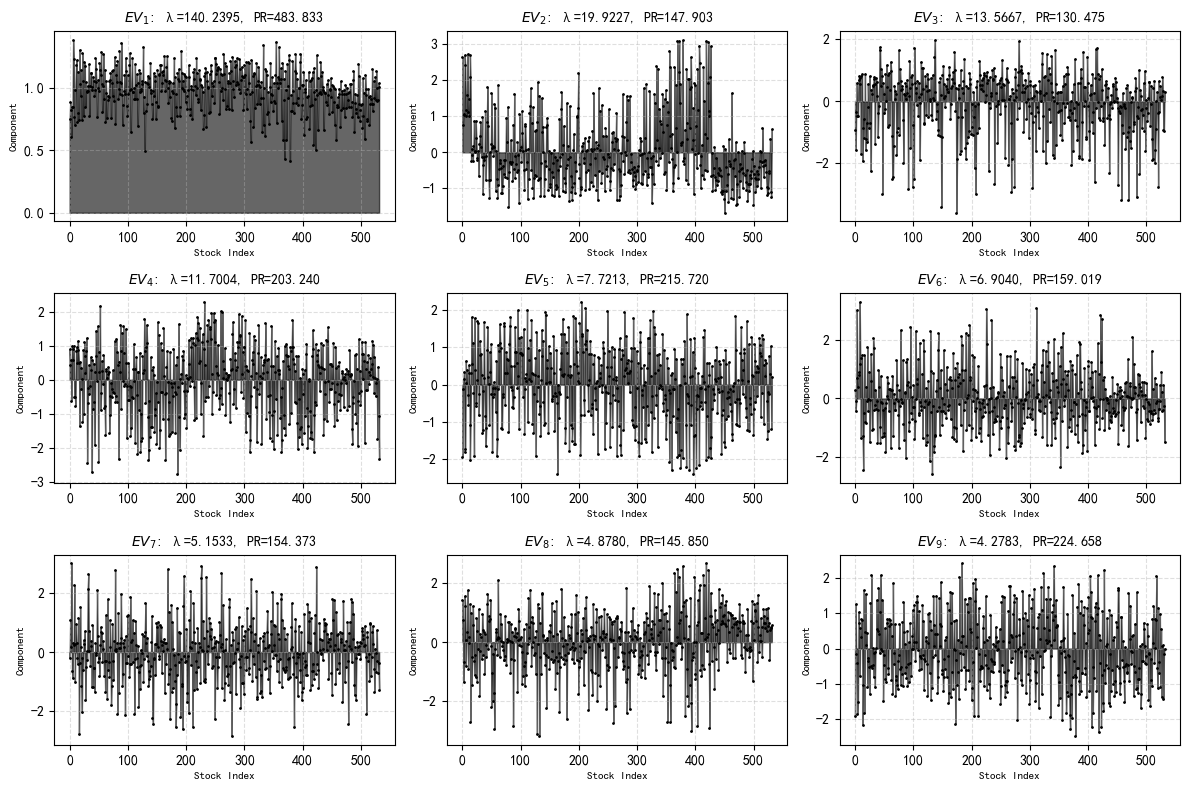

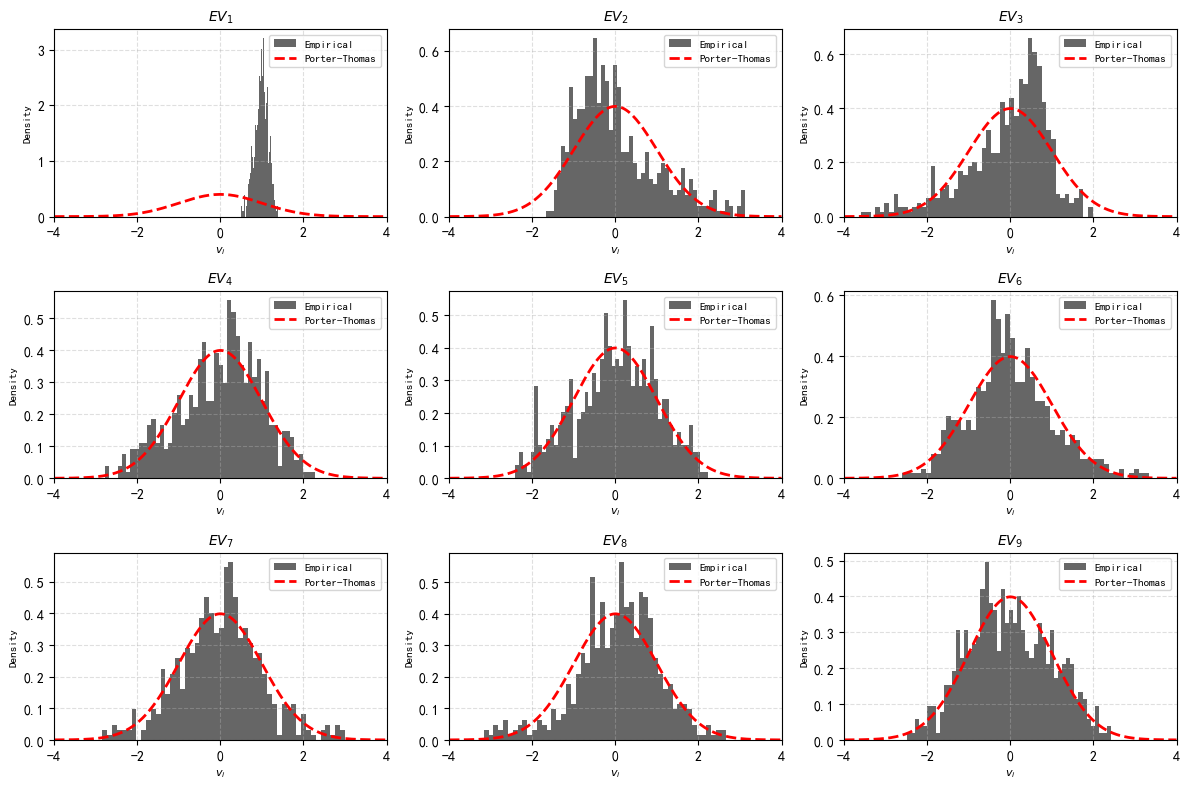

In [7]:
import numpy as np
import matplotlib.pyplot as plt

TOP_N_EVS = 9
N, K = h_desc.shape  # N 是股票数量
h_desc_norm = np.zeros_like(h_desc)

# --- 特征向量归一化（模方 = N） ---
for k in range(K):
    v = h_desc[:, k]
    h_desc_norm[:, k] = v / np.linalg.norm(v) * np.sqrt(N)

# --- 图 1：特征向量分量分布（3x3网格） ---
fig1, axes1 = plt.subplots(3, 3, figsize=(12, 8))
axes1 = axes1.flatten()

for k in range(TOP_N_EVS):
    vec = h_desc_norm[:, k]
    ax = axes1[k]
    ax.fill_between(range(N), vec, 0, alpha=0.6, color='black')
    ax.plot(range(N), vec, marker='.', linestyle='-', linewidth=0, markersize=2, color='black')
    ax.set_title(rf'$EV_{k+1}$: λ={e_desc[k]:.4f}, PR={PR[k]:.3f}', fontsize=10)
    ax.set_xlabel('Stock Index', fontsize=8)
    ax.set_ylabel('Component', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

# --- 图 2：特征向量分量分布概率直方图（横坐标 v_i） ---

fig2, axes2 = plt.subplots(3, 3, figsize=(12, 8))
axes2 = axes2.flatten()

for k in range(TOP_N_EVS):
    vec = h_desc_norm[:, k]
    ax = axes2[k]
    
    # 绘制直方图，限制数据在 -4~4
    vec_clipped = vec[(vec >= -4) & (vec <= 4)]
    ax.hist(vec_clipped, bins=50, density=True, alpha=0.6, color='black', label='Empirical')
    
    # 理论正态分布 N(0,1)
    x_theory = np.linspace(-4, 4, 200)
    normal_pdf = (1/np.sqrt(2*np.pi)) * np.exp(-x_theory**2 / 2)
    ax.plot(x_theory, normal_pdf, 'r--', lw=2, label='Porter-Thomas')
    
    ax.set_xlim(-4, 4)
    ax.set_title(rf'$EV_{k+1}$', fontsize=10)
    ax.set_xlabel(r'$v_i$', fontsize=8)
    ax.set_ylabel('Density', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()



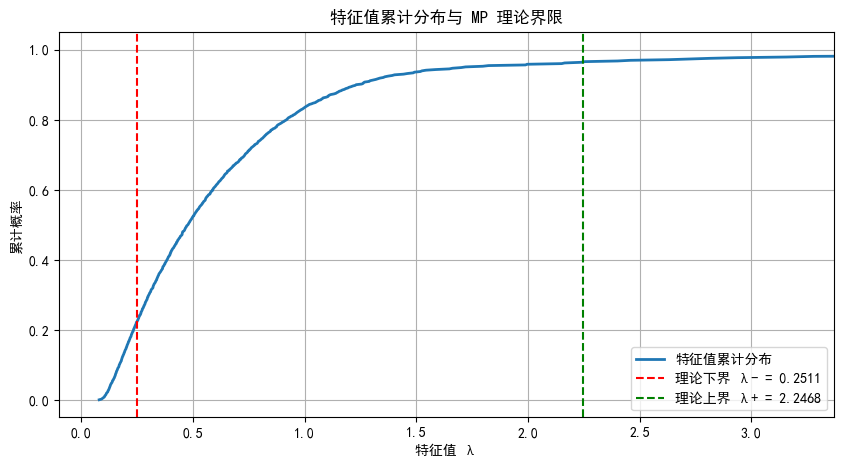

In [8]:
# ---------------- 绘制特征值累计分布 ----------------
import matplotlib.pyplot as plt
import numpy as np

# 特征值升序
e_sorted = np.sort(e_np)
# 计算累计概率
cdf = np.arange(1, len(e_sorted)+1) / len(e_sorted)

# ---------------- 绘制特征值累计分布（中文图例、右下角） ----------------
plt.figure(figsize=(10,5))
plt.plot(e_sorted, cdf, linewidth=2, label="特征值累计分布")
plt.axvline(lam_minus, color='r', linestyle='--', label=f"理论下界 λ- = {lam_minus:.4f}")
plt.axvline(lam_plus, color='g', linestyle='--', label=f"理论上界 λ+ = {lam_plus:.4f}")
plt.xlim(-0.1, lam_plus*1.5)
plt.xlabel("特征值 λ")
plt.ylabel("累计概率")
plt.title("特征值累计分布与 MP 理论界限")
plt.grid(True)
plt.legend(loc='lower right')  # 右下角
plt.show()



In [9]:
import akshare as ak
import pandas as pd
import os
from datetime import datetime

# ---------------- 配置 ----------------
DATA_DIR = './data_indices'  # 数据保存目录
os.makedirs(DATA_DIR, exist_ok=True)

INDEX_CONFIG = {
    'hs300': {
        'symbol': '000300',
        'name': '沪深300',
        'save_path': os.path.join(DATA_DIR, 'hs300_daily.csv'),
    },
    'sse': {
        'symbol': '000001',
        'name': '上证指数',
        'save_path': os.path.join(DATA_DIR, 'sse_daily.csv'),
    }
}

START_DATE = '20170101'
END_DATE = '20251024'


# ---------------- 下载指数日线 ----------------
def fetch_index_daily(symbol, name, save_path, start_date=START_DATE, end_date=END_DATE):
    print(f"开始下载{name}日线: {start_date} -> {end_date}")
    df = ak.index_zh_a_hist(symbol=symbol, period="daily", start_date=start_date, end_date=end_date)
    if df is not None and not df.empty:
        df = df.sort_values("日期")
        df['日期'] = pd.to_datetime(df['日期'])
        df.to_csv(save_path, index=False, encoding='utf-8-sig')
        print(f"✅ {name} 下载完成并保存到: {save_path}, 共 {len(df)} 条数据")
    else:
        print(f"⚠️ {name} 下载失败，数据为空")
    return df


# ---------------- 读取本地数据 ----------------
def load_index_daily(symbol, name, save_path, start_date=START_DATE, end_date=END_DATE):
    if os.path.exists(save_path):
        df = pd.read_csv(save_path, dtype={'日期': str})
        df = df.sort_values("日期")
        df['日期'] = pd.to_datetime(df['日期'])
        df = df[(df['日期'] >= pd.to_datetime(start_date)) & (df['日期'] <= pd.to_datetime(end_date))]
        print(f"✅ 从本地缓存加载{name}日线，共 {len(df)} 条数据")
        return df
    else:
        print(f"⚠️ {name}本地文件不存在，将自动下载")
        return fetch_index_daily(symbol, name, save_path, start_date, end_date)


# ---------------- 主流程 ----------------
def load_all_indices():
    dfs = {}
    for key, cfg in INDEX_CONFIG.items():
        df = load_index_daily(cfg['symbol'], cfg['name'], cfg['save_path'])
        dfs[key] = df
        print(f"\n{name}数据预览：")
        print(df.head())
        print(df.tail())
        print("-" * 80)
    return dfs


# ---------------- 执行 ----------------
if __name__ == "__main__":
    all_indices = {}
    for key, cfg in INDEX_CONFIG.items():
        df = load_index_daily(cfg['symbol'], cfg['name'], cfg['save_path'])
        all_indices[key] = df

    print("\n✅ 数据加载完成，索引：", list(all_indices.keys()))
    print(all_indices['hs300'].head())
    print(all_indices['sse'].head())


✅ 从本地缓存加载沪深300日线，共 2138 条数据
✅ 从本地缓存加载上证指数日线，共 2138 条数据

✅ 数据加载完成，索引： ['hs300', 'sse']
          日期       开盘       收盘       最高       最低       成交量           成交额  \
0 2017-01-03  3313.95  3342.23  3345.26  3313.95  86567896  8.761277e+10   
1 2017-01-04  3340.56  3368.31  3369.57  3338.15  90050827  9.801436e+10   
2 2017-01-05  3368.34  3367.79  3373.41  3361.46  88336357  9.118934e+10   
3 2017-01-06  3366.85  3347.67  3368.87  3346.89  87459114  9.107226e+10   
4 2017-01-09  3345.75  3363.90  3366.22  3344.35  83707942  8.791612e+10   

     振幅   涨跌幅    涨跌额   换手率  
0  0.95  0.97  32.15  0.26  
1  0.94  0.78  26.08  0.28  
2  0.35 -0.02  -0.52  0.27  
3  0.65 -0.60 -20.12  0.27  
4  0.65  0.48  16.23  0.26  
          日期       开盘       收盘       最高       最低        成交量           成交额  \
0 2017-01-03  3105.31  3135.92  3136.46  3105.31  141567186  1.598871e+11   
1 2017-01-04  3133.79  3158.79  3160.10  3130.11  167860851  1.959143e+11   
2 2017-01-05  3157.91  3165.41  3168.50  3154.28  17

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import math
def denoise_by_bulk_mean(vals, vecs, T, N):
    """Replace bulk eigenvalues (inside MP bounds) with bulk mean"""
    lam_minus, lam_plus = marchenko_pastur(T / N)
    in_bulk = (vals >= lam_minus) & (vals <= lam_plus)
    lam_d = vals.copy()
    if np.any(in_bulk):
        lam_d[in_bulk] = np.mean(vals[in_bulk])
    denoised = vecs @ np.diag(lam_d) @ vecs.T
    denoised = (denoised + denoised.T) / 2.0  # symmetrize
    return denoised, lam_d

# ---------------- RMT 去噪函数 ----------------
def marchenko_pastur(Q):
    lam_plus = (1 + 1.0 / math.sqrt(Q))**2
    lam_minus = (1 - 1.0 / math.sqrt(Q))**2
    return lam_minus, lam_plus

def denoise_three_region(vals, vecs, T, N):
    lam_minus, lam_plus = marchenko_pastur(T / N)
    lam_d = vals.copy()
    bulk_idx = (vals >= lam_minus) & (vals <= lam_plus)
    small_idx = vals < lam_minus
    large_idx = vals > lam_plus
    if np.any(bulk_idx):
        lam_d[bulk_idx] = np.mean(vals[bulk_idx])
    if np.any(small_idx):
        lam_d[small_idx] = lam_minus
    denoised = vecs @ np.diag(lam_d) @ vecs.T
    denoised = (denoised + denoised.T) / 2.0
    return denoised, lam_d

# ---------------- 最小方差 + beta 约束权重 ----------------
def minvar_weights_beta(cov_mat, betas, beta_target=1, long_only=True):
    n = cov_mat.shape[0]
    if n == 0:
        return np.array([])
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov_mat))
    constraints = [cp.sum(w) == 1]
    if beta_target is not None and len(betas) == n:
        constraints.append(w @ betas == beta_target)
    if long_only:
        constraints.append(w >= 0)
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS, warm_start=True)
    if w.value is None:
        return np.ones(n) / n
    return np.array(w.value).flatten()

# ---------------- RMT 滚动最小方差回测 ----------------
def rmt_minvar_rolling_backtest(
    P_stocks, codes, dates=None,
    P_hs300=None, hs300_dates=None,
    P_sse=None, sse_dates=None,
    lookback_rmt=1000, top_ev_index=0, top_n_select=50,
    rebalance=21, long_only=True,
    beta_target=1,
    selection_mode='pos_neg',  # 'positive','negative','pos_neg','abs'
    denoise_select=True        # 是否用去噪矩阵选股
):
    N, T_total = P_stocks.shape
    returns_all = np.log(P_stocks[:,1:] / P_stocks[:,:-1]).T
    dates_all = pd.to_datetime(dates[1:]) if dates is not None else pd.Series(np.arange(T_total-1))

    # --- 对齐指数收益 ---
    def compute_returns(P, P_dates):
        df = pd.DataFrame({'price': P[1:], 'date': pd.to_datetime(P_dates[1:])})
        df = df.set_index('date').reindex(dates_all, method='ffill')
        ret = np.log(df['price']/df['price'].shift(1)).fillna(0).values
        return ret
    returns_hs300 = compute_returns(P_hs300, hs300_dates) if P_hs300 is not None else None
    returns_sse = compute_returns(P_sse, sse_dates) if P_sse is not None else None

    # --- 计算 beta ---
    if P_sse is not None:
        base_ret = np.log(P_sse[1:]/P_sse[:-1])
    elif P_hs300 is not None:
        base_ret = np.log(P_hs300[1:]/P_hs300[:-1])
    else:
        base_ret = None
    betas_all = np.ones(N) if base_ret is None else np.array([
        np.cov(np.log(P_stocks[i,1:]/P_stocks[i,:-1])[-len(base_ret):], base_ret[-len(base_ret):])[0,1] / 
        (np.var(base_ret[-len(base_ret):]) if np.var(base_ret[-len(base_ret):]) !=0 else 1.0)
        for i in range(N)
    ])

    # --- 初始化回测 ---
    port_ret_raw = np.zeros(T_total-1)
    port_ret_denoised = np.zeros(T_total-1)
    port_ret_hs300 = np.zeros(T_total-1) if returns_hs300 is not None else None
    port_ret_sse = np.zeros(T_total-1) if returns_sse is not None else None
    selected_stocks_list, weights_raw_list, weights_denoised_list, rebalance_indices = [], [], [], []

    # --- 回测循环 ---
    for t in range(lookback_rmt, T_total-1, rebalance):
        window_ret = returns_all[t-lookback_rmt:t, :]
        cov_raw = np.cov(window_ret, rowvar=False)
        cov_denoised_full, _ = denoise_three_region(*np.linalg.eigh(cov_raw), lookback_rmt, N)

        # --- 原始协方差组合 ---
        e_vals_raw, e_vecs_raw = np.linalg.eigh(cov_raw)
        idx_desc_raw = np.argsort(e_vals_raw)[::-1]
        e_vals_desc_raw, e_vecs_desc_raw = e_vals_raw[idx_desc_raw], e_vecs_raw[:, idx_desc_raw]
        target_vec_raw = e_vecs_desc_raw[:, top_ev_index]
        selected_idx_raw = select_top_indices(target_vec_raw, top_n_select, selection_mode)
        betas_sel_raw = betas_all[selected_idx_raw]
        cov_sel_raw = cov_raw[np.ix_(selected_idx_raw, selected_idx_raw)]
        w_raw = minvar_weights_beta(cov_sel_raw, betas_sel_raw, beta_target, long_only)

        # --- 去噪协方差组合 ---
        e_vals_dn, e_vecs_dn = np.linalg.eigh(cov_denoised_full)
        idx_desc_dn = np.argsort(e_vals_dn)[::-1]
        e_vals_desc_dn, e_vecs_desc_dn = e_vals_dn[idx_desc_dn], e_vecs_dn[:, idx_desc_dn]
        target_vec_dn = e_vecs_desc_dn[:, top_ev_index]

        # 是否用去噪矩阵选股
        if denoise_select:
            selected_idx_dn = select_top_indices(target_vec_dn, top_n_select, selection_mode)
        else:
            # 用原始协方差的target_vec选股
            selected_idx_dn = select_top_indices(target_vec_raw, top_n_select, selection_mode)

        betas_sel_dn = betas_all[selected_idx_dn]
        cov_sel_dn = cov_denoised_full[np.ix_(selected_idx_dn, selected_idx_dn)]
        w_denoised = minvar_weights_beta(cov_sel_dn, betas_sel_dn, beta_target, long_only)

        # --- 更新收益 ---
        end_idx = min(t+rebalance, T_total-1)
        port_ret_raw[t:end_idx] = returns_all[t:end_idx, :][:, selected_idx_raw] @ w_raw
        port_ret_denoised[t:end_idx] = returns_all[t:end_idx, :][:, selected_idx_dn] @ w_denoised
        if returns_hs300 is not None:
            port_ret_hs300[t:end_idx] = returns_hs300[t:end_idx]
        if returns_sse is not None:
            port_ret_sse[t:end_idx] = returns_sse[t:end_idx]

        selected_stocks_list.append([codes[i] for i in selected_idx_dn])
        weights_raw_list.append(w_raw)
        weights_denoised_list.append(w_denoised)
        rebalance_indices.append(t)

    # --- 累积收益 ---
    port_ret_raw = port_ret_raw[lookback_rmt:]
    port_ret_denoised = port_ret_denoised[lookback_rmt:]
    if port_ret_hs300 is not None:
        port_ret_hs300 = port_ret_hs300[lookback_rmt:]
    if port_ret_sse is not None:
        port_ret_sse = port_ret_sse[lookback_rmt:]

    plot_dates = dates_all[lookback_rmt:]
    cum_raw = np.exp(np.cumsum(port_ret_raw))
    cum_denoised = np.exp(np.cumsum(port_ret_denoised))
    cum_hs300 = np.exp(np.cumsum(port_ret_hs300)) if port_ret_hs300 is not None else None
    cum_sse = np.exp(np.cumsum(port_ret_sse)) if port_ret_sse is not None else None

    plt.figure(figsize=(12,6))
    plt.plot(plot_dates, cum_raw, label='原始协方差ETF', color='orange')
    plt.plot(plot_dates, cum_denoised, label='去噪协方差ETF', color='green')
    if cum_hs300 is not None:
        plt.plot(plot_dates, cum_hs300, label='沪深300', color='blue', linestyle='--')
    if cum_sse is not None:
        plt.plot(plot_dates, cum_sse, label='上证', color='purple', linestyle='--')
    plt.title(f'RMT滚动最小方差组合 (EV {top_ev_index+1}, lookback={lookback_rmt}, rebalance={rebalance}, β={beta_target})')
    plt.xlabel('日期')
    plt.ylabel('累计收益')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

    # --- 简单统计指标 ---
    def metrics(port_ret):
        if port_ret is None or len(port_ret)==0:
            return (np.nan,np.nan,np.nan)
        mean = np.nanmean(port_ret)*252
        vol = np.nanstd(port_ret)*np.sqrt(252)
        sharpe = mean/vol if vol!=0 else np.nan
        return mean, vol, sharpe

    print("Raw Cov:", metrics(port_ret_raw))
    print("Denoised Cov:", metrics(port_ret_denoised))
    if port_ret_hs300 is not None:
        print("HS300:", metrics(port_ret_hs300))
    if port_ret_sse is not None:
        print("SSE:", metrics(port_ret_sse))

    return {
        'cum_raw': cum_raw,
        'cum_denoised': cum_denoised,
        'cum_hs300': cum_hs300,
        'cum_sse': cum_sse,
        'selected_stocks_list': selected_stocks_list,
        'weights_raw_list': weights_raw_list,
        'weights_denoised_list': weights_denoised_list,
        'rebalance_indices': rebalance_indices,
        'betas_all': betas_all,
    }

# --- 帮助函数：根据target_vec选股 ---
def select_top_indices(target_vec, top_n_select, selection_mode, verbose=False):
    if selection_mode == 'abs':
        return np.argsort(np.abs(target_vec))[::-1][:top_n_select]
    elif selection_mode == 'positive':
        pos_order = np.argsort(target_vec)[::-1]
        return [i for i in pos_order if target_vec[i] > 0][:top_n_select]
    elif selection_mode == 'negative':
        neg_order = np.argsort(target_vec)
        return [i for i in neg_order if target_vec[i] < 0][:top_n_select]
    elif selection_mode == 'pos_neg':
        pos_order = np.argsort(target_vec)[::-1]
        neg_order = np.argsort(target_vec)
        n_each = top_n_select // 2

        idx_pos = [i for i in pos_order if target_vec[i] > 0][:n_each]
        idx_neg = [i for i in neg_order if target_vec[i] < 0][:n_each]

        # 如果正/负股票不够，从剩余股票中补齐
        actual_pos = len(idx_pos)
        actual_neg = len(idx_neg)
        remaining = top_n_select - (actual_pos + actual_neg)
        if remaining > 0:
            rest_idx = [i for i in range(len(target_vec)) if i not in idx_pos + idx_neg]
            idx_extra = rest_idx[:remaining]
        else:
            idx_extra = []

        selected_idx = idx_pos + idx_neg + idx_extra

        if verbose:
            print(f"选股数量：正={actual_pos}, 负={actual_neg}, 补齐={len(idx_extra)}, 总={len(selected_idx)}")

        return selected_idx
    else:
        raise ValueError(f"Unknown selection_mode: {selection_mode}")





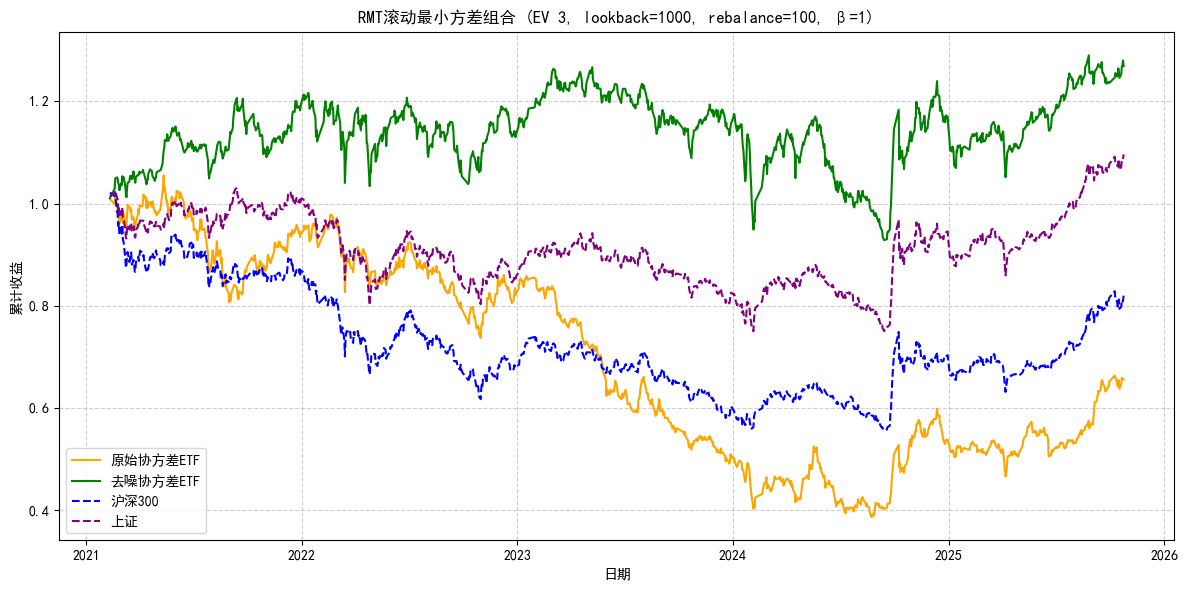

Raw Cov: (-0.09349334235941227, 0.23373569631464133, -0.3999959947647748)
Denoised Cov: (0.052854387668697204, 0.18777170228693302, 0.2814821776921992)
HS300: (-0.044081076653635816, 0.1813231217316469, -0.2431078630935693)
SSE: (0.020366395435328418, 0.15908571786506118, 0.12802152015056117)


In [11]:

df_hs300 = pd.read_csv('./data_indices/hs300_daily.csv')
df_hs300['日期'] = pd.to_datetime(df_hs300['日期'])
df_sse = pd.read_csv('./data_indices/sse_daily.csv')
df_sse['日期'] = pd.to_datetime(df_sse['日期'])
# 然后运行
result = rmt_minvar_rolling_backtest(
    P_stocks=P,
    codes=codes,
    dates=dates,
    P_hs300=df_hs300['收盘'].values,
    hs300_dates=df_hs300['日期'].values,
    P_sse=df_sse['收盘'].values,
    sse_dates=df_sse['日期'].values,
    lookback_rmt=1000,
    top_ev_index=2,
    top_n_select=50,
    rebalance=100,
    long_only=True,
    beta_target = 1,
    selection_mode='pos_neg',
    denoise_select=True,
)
